In [1273]:
#imports
import os
import pandas as pd
import networkx as nx
from networkx.readwrite import json_graph
from matplotlib.pyplot import figure
import numpy as np
import json
from openpyxl import load_workbook
from unicodedata import normalize


In [1274]:
dir = "planilhas/"

def get_file_name(filepath):
    """Lista os arquivos da pasta"""
    f = os.listdir(filepath)
    files = [os.path.splitext(filename)[0] for filename in os.listdir(dir)]
    return files

In [1275]:
def get_sheet_names_xlsx(filepath):
    """Lista a sheet do arquivo"""
    wb = load_workbook(filepath, read_only=True, keep_links=False)
    return wb.sheetnames

In [1276]:
def get_all_files():
    """Loop para listar todos os arquivos e suas sheets
def get_all_files():"""
    f = np.array(get_file_name(dir))
    sheets = []
    file_name = []
    for i in range(len(f)):
        file_name.append(f.item(i))
        s = get_sheet_names_xlsx(dir+file_name[i]+".xlsx")
        s_as_string = ' '.join([str(elem) for elem in s])   #converte a lista para string
        sheets.append(s_as_string)                          #nova lista
    print("Files: {}".format(file_name))
    print("Sheets: {}".format(sheets))
    return convert_all_to_json(dir, file_name, sheets, ".xlsx")

In [1277]:
def convert_to_json(dir, file_name, sheet_name, ext):
    """Converte excel para Json"""
    excel_data_df = pd.read_excel(dir + file_name + ext, sheet_name=sheet_name)
    json_str = excel_data_df.to_json(orient='records')
    #print("The original dictionary is : {}".format(json_str))
    return handle_accentuation_json(json_str)

In [1278]:
def handle_accentuation_json(json_str):
    """Tratamento de acentuação no Json"""
    json_str = json_str.encode("latin1").decode("unicode_escape")
    json_result = normalize('NFKD', json_str).encode('ASCII', 'ignore').decode('ASCII')
    #print(json_result)
    return json_result


In [1279]:
def convert_all_to_json(dir, f, sheet_name, ext):
    """Loop para converter para Json"""
    list_json = []
    for i in range(len(f)):
        parsed =  json.loads(convert_to_json(dir, str(f[i]), sheet_name[i], ext))
        json_data = (json.dumps(parsed, indent=4, sort_keys=False))
        list_json.append(parsed)
    # printing Structed dictionary
    # print("The structed dictionary is : {}".format(list_json))
    return save_json(list_json)

In [1280]:
def save_json(json_data):
    """Salva a estrutura JSON criada"""
    file_name = 'output/data.json'
    with open(file_name, 'w') as outfile:
        json.dump(json_data, outfile, indent=4)
    return convert_json_to_pandasDF(json_data)


In [1281]:
def convert_json_to_pandasDF(json_data):
    """Converte o Json em um dataframe"""
    json_list = [item for sublist in json_data for item in sublist]
    dataset = pd.json_normalize(json_list)
    dataset = pd.DataFrame(dataset)
    # print(dataset.head(10))
    print(dataset.columns)
    return cleansing_data(dataset)

In [1282]:
def cleansing_data(df):
    """Limpeza e tratamento de dados"""
    df = df[['Fonte', 'Conexao', 'Velocidade ( Giga )']]
    df.rename(columns={'Velocidade ( Giga )': 'Giga'}, inplace = True)
    df.dropna(subset=['Conexao'], inplace=True)
    df.fillna(0, inplace=True)
    df= df[df['Conexao'] != "None"]
    print(df.head(10))
    print(df.shape)
    return graph_generator(df)

In [1283]:
def graph_generator(df):
    """Geração do grafo """
    df['Velocidade ( Giga )'] = df['Giga'].values
    G =nx.from_pandas_edgelist(df, 'Fonte', 'Conexao', 'Giga')
    labels = nx.get_edge_attributes(G,'Giga')
    pos=nx.shell_layout(G)# positions for all nodes
    print(nx.info(G))

    #grafo
    figure(figsize=(20,20))
    nx.draw_shell(G, with_labels=True,edge_color =  'r', node_size=1500, alpha = .95, node_color='c')
    nx.draw_networkx_edge_labels(G, pos=pos)

Files: ['cmn01', 'core01', 'core02', 'icr01', 'pacs01']
Sheets: ['PORTAS_CORE', 'PORTAS_CORE', 'PORTAS_CORE', 'PORTAS_CORE', 'PORTAS_CORE']
Index(['Fonte', 'Porta', 'Conexao', 'Descricao', 'DIO', 'Velocidade ( Giga )',
       'Alteracao'],
      dtype='object')
     Fonte  Conexao  Giga
0    CMN01   CORE01  10.0
1    CMN01  AGG_CMN  10.0
2    CMN01      IPQ  10.0
3    CMN01    INRAD  10.0
4    CMN01     PABX  10.0
6   CORE01   ICHC01  10.0
7   CORE01      IPQ   1.0
9   CORE01    EEP01  10.0
10  CORE01   PABX01  10.0
11  CORE01    CDM01   1.0
(68, 3)
Name: 
Type: Graph
Number of nodes: 44
Number of edges: 48
Average degree:   2.1818


<ipython-input-1278-f6524f08ca63>:3: DeprecationWarning: invalid escape sequence '\/'
  json_str = json_str.encode("latin1").decode("unicode_escape")
E:\progamas\anaconda\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-1282-0d050bd7bac2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Conexao'], inplace=True)
E:\progamas\anaconda\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

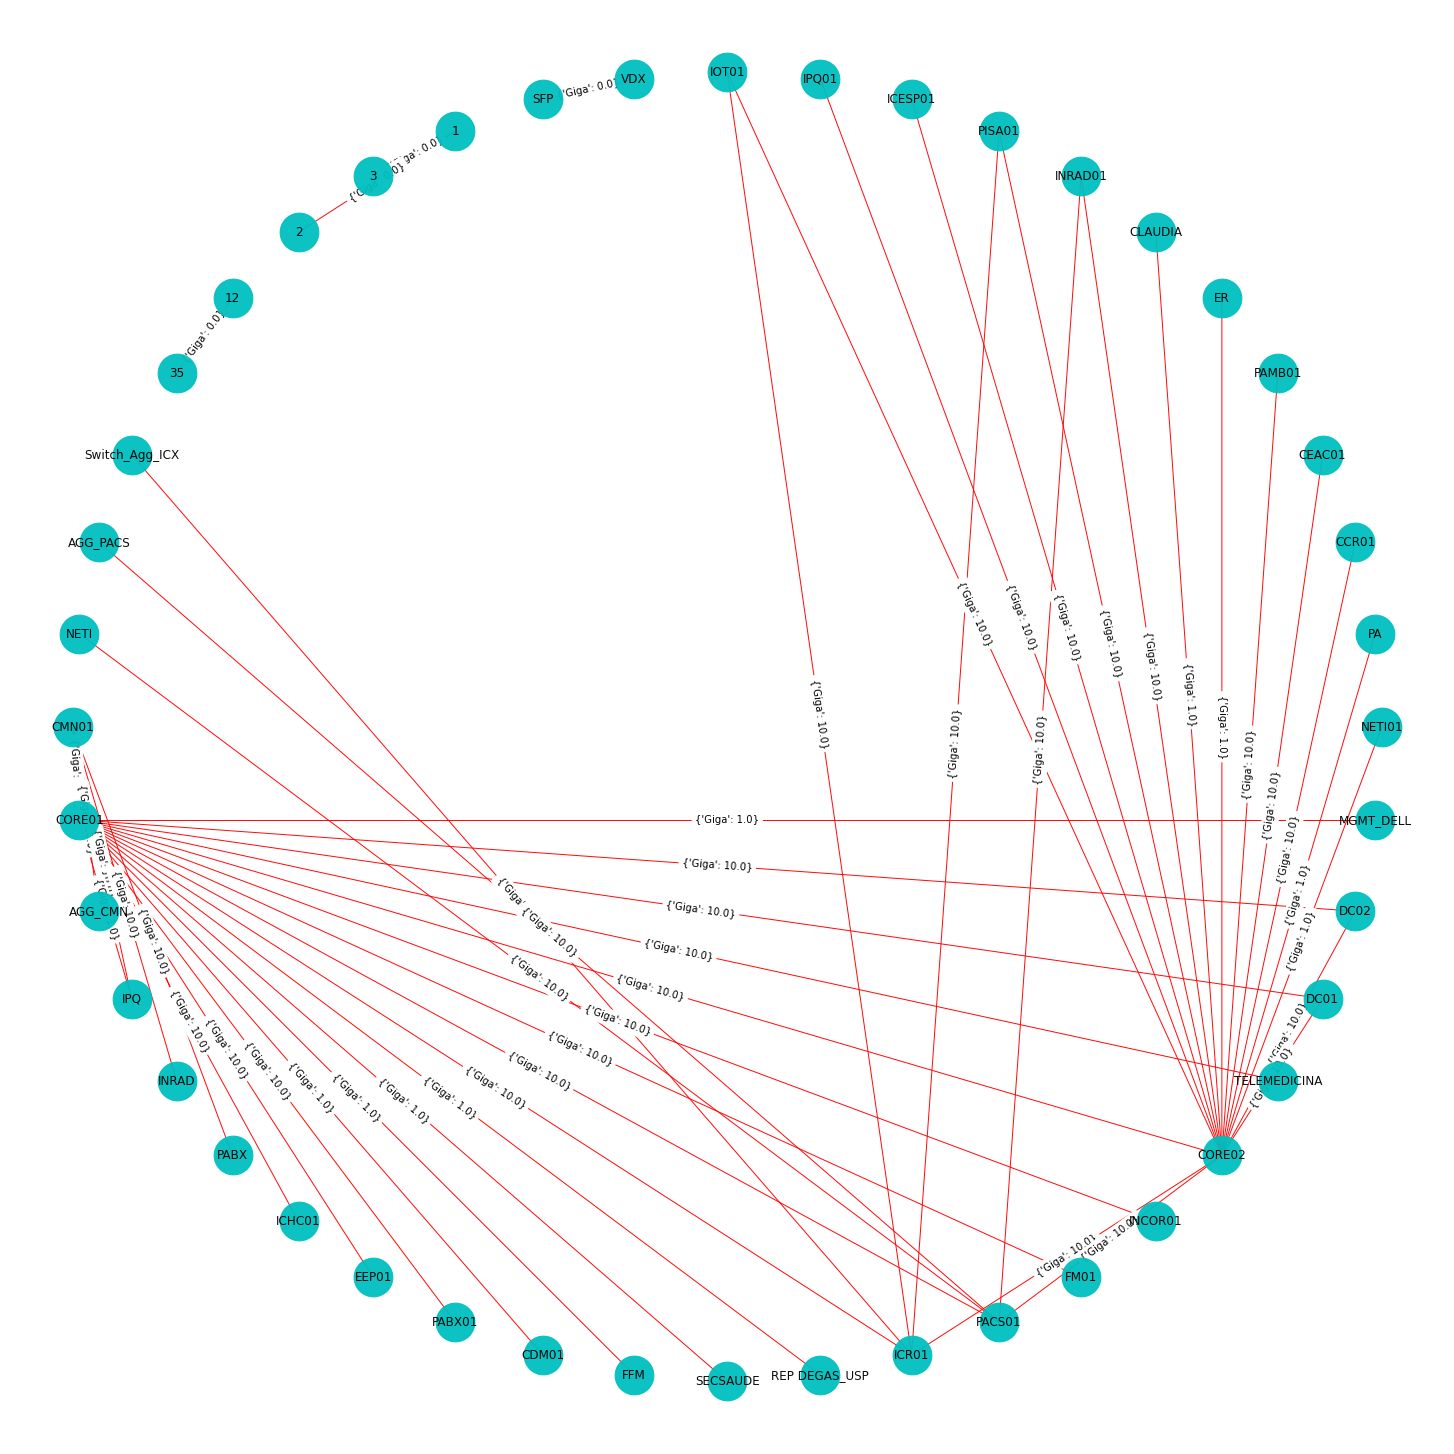

In [1284]:
#chamada funções
def main():
    get_all_files()

#main
if __name__ == '__main__':
    main()